In [2]:
import os
import pandas as pd

#this directory contains the csv with all the models' metrics, and all tables generated in this notebook will go here
results_path = "./results/5_final_results/"
models_path = "./models/5_final_results/"

In [14]:
#load results
results = pd.read_csv(os.path.join(results_path, "mean.csv"))
#make all the strings 7 digits long by adding zeros in front
results["name"] = results.apply(lambda row: "M" + str(int(row["name"])).zfill(7), axis=1)

#obtain the relative orders of each column, keeping the column name
ranks = results.drop("name", axis=1).rank(ascending=False).add_suffix("_rank")
ranked_results = pd.concat([results, ranks], axis=1)

#find the product of the ranks of each column
metrics_to_eval = ["botwiki-verified_rank", "midterm-18_rank", "gilani-17_rank", "cresci-rtbust_rank", "5-fold_cross-validation_rank", "spearman_r_rank"]
rank_product = ranked_results[metrics_to_eval].product(axis=1)


#drop the ranks of the test metrics since they aren't useful in the tables
ranked_results = ranked_results.drop(labels=ranked_results.columns[7:],axis=1)


#get the rank of the products (used for a lookup later)
ranked_results["rank"] = rank_product.rank(ascending=True)



In [15]:
#get the best n results
n = 3

#once rank is calculated, round all metrics for readability
def round_except_1(val):
    if round(val, 2) == 1:
        return 0.99
    return round(val,2)
    
top_results = ranked_results.sort_values("rank").head(n).set_index("name").transpose().applymap(round_except_1)

top_results_file = os.path.join(results_path, "top_results.csv")
top_results.to_csv(top_results_file)

top_models = top_results.columns
top_model = top_models[0]

top_results

name,M0101000,M0101010,M1010010
botwiki-verified,0.99,0.99,0.98
midterm-18,0.98,0.98,0.96
gilani-17,0.65,0.68,0.76
cresci-rtbust,0.76,0.68,0.64
5-fold_cross-validation,0.99,0.99,0.99
spearman_r,0.67,0.63,0.69
rank,0.99,2.00,3.00


In [16]:
n = 25
top_result_names = ranked_results.sort_values("rank").head(n)["name"]
top_result_names

dataset_list = ["varol", "cresci-17", "pronbots", "celebrity", "vendor-purchased", "botometer-feedback", "political-bots"]
dataset_count = [0] * len(dataset_list)

#given a dataset appearing in a row, what is the prob it appeared alongside the given column
conditional_prob = pd.DataFrame(0, index=dataset_list, columns=dataset_list)

#get counts of dataset appearences in top 20 ranked, and their co_occurences
for name in top_result_names:
  indices = [i for i, char in enumerate(name.strip("M")) if char == "1"]
  for i in indices:
    dataset_count[i] += 1
    for j in indices:
      #indexing is [col][row]
      conditional_prob[dataset_list[i]][dataset_list[j]] += 1

for i, dataset in enumerate(dataset_list):
  print(f"{dataset}: {dataset_count[i] / n:.3f}")    

print(dataset_count)
conditional_table = conditional_prob.divide(dataset_count, axis='index').round(decimals=2)
conditional_table

varol: 0.160
cresci-17: 0.440
pronbots: 0.560
celebrity: 0.400
vendor-purchased: 0.280
botometer-feedback: 0.800
political-bots: 0.440
[4, 11, 14, 10, 7, 20, 11]


,varol,cresci-17,pronbots,celebrity,vendor-purchased,botometer-feedback,political-bots
varol,1.00,0.00,1.00,0.00,0.50,1.00,0.50
cresci-17,0.00,1.00,0.27,0.64,0.00,0.55,0.45
pronbots,0.29,0.21,1.00,0.43,0.36,0.93,0.43
celebrity,0.00,0.70,0.60,1.00,0.10,0.70,0.40
vendor-purchased,0.29,0.00,0.71,0.14,1.00,1.00,0.43
botometer-feedback,0.20,0.30,0.65,0.35,0.35,1.00,0.45
political-bots,0.18,0.45,0.55,0.36,0.27,0.82,1.00


[Text(0.5, 0, 'varol'),
 Text(1.5, 0, 'cresci-17'),
 Text(2.5, 0, 'pronbots'),
 Text(3.5, 0, 'celebrity'),
 Text(4.5, 0, 'vendor-purchased'),
 Text(5.5, 0, 'botometer-feedback'),
 Text(6.5, 0, 'political-bots')]

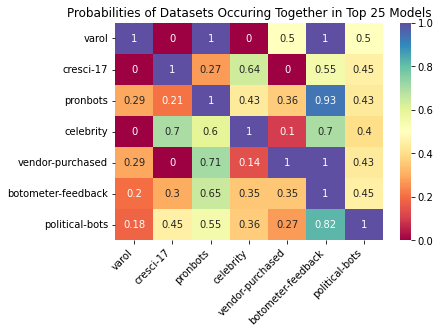

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

graph = sns.heatmap(data=conditional_table, annot=True, cmap="Spectral")

graph.set_title(f"Probabilities of Datasets Occuring Together in Top {n} Models")

graph.set_xticklabels(graph.get_xticklabels(), rotation=45, horizontalalignment='right')

#plt.xticks(rotation=45)

In [18]:
#get the ranks of the models in original table 4 for comparison
lookup_names = ["M1101011", "M1101010", "M1101110", "M1111111"]
table4 = ranked_results.loc[ranked_results['name'].isin(lookup_names)]

#get the names used in the paper
model_name_conversion = {"M1101011": "M196",
                         "M1101010": "M125",
                         "M1101110": "M191",
                         "M1111111": "M246_revised"}
table4['name'] = table4.apply(lambda row: model_name_conversion[row['name']], axis=1)

#reorder to have models in same order as paper
table4 = table4.set_index("name").transpose()[["M196", "M125", "M191", "M246_revised"]]

table4_file = os.path.join(results_path, "table4.csv")
table4.to_csv(table4_file)
table4

/tmp/ipykernel_338/3850043466.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table4['name'] = table4.apply(lambda row: model_name_conversion[row['name']], axis=1)


name,M196,M125,M191,M246_revised
botwiki-verified,0.976445,0.976907,0.976310,0.980556
midterm-18,0.954154,0.956299,0.962986,0.966392
gilani-17,0.688437,0.680251,0.681520,0.674982
cresci-rtbust,0.617694,0.646842,0.646209,0.635290
5-fold_cross-validation,0.990705,0.990380,0.987928,0.994277
spearman_r,0.486382,0.478350,0.498116,0.546170
rank,90.000000,91.000000,84.000000,61.000000


In [9]:
# Seven training datasets
dataset_path = "data_csv/final"

varol = pd.read_csv(dataset_path + '/varol-17.csv')
cresci_17 = pd.read_csv(dataset_path + '/cresci-17.csv')
pronbots = pd.read_csv(dataset_path + '/pronbots-2019.csv')
celebrity = pd.read_csv(dataset_path + '/celebrity-2019.csv')
vendor = pd.read_csv(dataset_path + '/vendor-purchased-2019.csv')
botometer = pd.read_csv(dataset_path + '/botometer-feedback-2019.csv')
political = pd.read_csv(dataset_path + '/political-bots-2019.csv')

# Testing datasets
botwiki = pd.read_csv(dataset_path + '/botwiki-verified.csv')
midterm = pd.read_csv(dataset_path + '/midterm-2018.csv')
gilani = pd.read_csv(dataset_path + '/gilani-2017.csv')
c_rtbust = pd.read_csv(dataset_path + '/cresci-rtbust-2019.csv')

In [12]:
#get the breakdown of how many observations are in each class for all datasets

datasets = [varol, cresci_17, pronbots, celebrity, vendor, botometer, political, botwiki, midterm, gilani, c_rtbust]
dataset_names = ["varol-icwsm", "cresci-17", "pronbots", "celebrity", "vendor-purchased", "botometer-feedback", "political-bots", "botwiki-verified", "midterm-18", "gilani-17", "cresci-rtbust"]

dataset_analysis = []
for i, dataset in enumerate(datasets):
  name = dataset_names[i]
  bots = sum(dataset['is_bot'] == 1)
  humans = sum(dataset['is_bot'] == 0)
  dataset_analysis.append([name, bots, humans])

dataset_analysis

[['varol-icwsm', 665, 1441],
 ['cresci-17', 6543, 3474],
 ['pronbots', 17882, 0],
 ['celebrity', 0, 5918],
 ['vendor-purchased', 1087, 0],
 ['botometer-feedback', 138, 380],
 ['political-bots', 62, 0],
 ['botwiki-verified', 698, 1987],
 ['midterm-18', 42446, 8092],
 ['gilani-17', 1090, 1394],
 ['cresci-rtbust', 353, 340]]

In [14]:
import joblib
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict, StratifiedShuffleSplit, ShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [38]:
#do the top_model or the m196 model
show_top_model = True


all_test_data = pd.concat([botwiki, gilani, midterm, c_rtbust], ignore_index=True)

top_model_stripped = top_model.strip("M")
top_model_cv_data = pd.concat([datasets[i] for i, c in enumerate(top_model_stripped) if c == "1"], ignore_index=True)

m196_cv_data = pd.concat([varol, cresci_17, celebrity, botometer, political], ignore_index=True)


all_test_data_X = all_test_data.drop("is_bot", axis=1)
all_test_data_Y = all_test_data["is_bot"]

m196_cv_data_X = m196_cv_data.drop("is_bot", axis=1)
m196_cv_data_Y = m196_cv_data["is_bot"]

top_model_cv_data_X = top_model_cv_data.drop("is_bot", axis=1)
top_model_cv_data_Y = top_model_cv_data["is_bot"]

In [41]:
model_cv_X = top_model_cv_data_X if show_top_model else m196_cv_data_X
model_cv_Y = top_model_cv_data_Y if show_top_model else m196_cv_data_Y

#5 fold cross validation

clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=0)

ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
splits = ss.split(X=model_cv_X, y=model_cv_Y)

cv_predicted = pd.DataFrame(columns=["bot_prob"])
cv_Y = np.array([])

for split in splits:
  train, test = split
  
  train_X = model_cv_X.iloc[train]
  train_Y = model_cv_Y.iloc[train]
  test_X = model_cv_X.iloc[test]
  test_Y = model_cv_Y.iloc[test]
  clf.fit(train_X, train_Y)


  cv_bot_scores =  pd.DataFrame(clf.predict_proba(test_X), columns = ["human_prob", "bot_prob"])
  predicted = cv_bot_scores.drop("human_prob", axis=1)

  #the predicted values are dataframes, the cv_Y values are numpy arrays
  cv_predicted = pd.concat([cv_predicted, predicted], ignore_index=True)
  cv_Y = np.concatenate((cv_Y, test_Y))

print(cv_predicted)
print(cv_Y)

       bot_prob
0          0.00
1          1.00
2          0.91
3          1.00
4          1.00
...         ...
15930      0.00
15931      0.01
15932      1.00
15933      1.00
15934      0.00

[15935 rows x 1 columns]
[0. 1. 1. ... 1. 1. 0.]


In [47]:
m196 = joblib.load(os.path.join(models_path, "1101011.joblib"))

best_model = joblib.load(os.path.join(models_path, f"{top_model_stripped}.joblib"))

model = best_model if show_top_model else m196

test_data_bot_scores =  pd.DataFrame(model.predict_proba(all_test_data_X), columns = ["human_prob", "bot_prob"])
test_data_predicted = test_data_bot_scores.drop("human_prob", axis=1)

#this is used for the bot scores distribution plot
predicted = pd.DataFrame()
predicted["cv"] = cv_predicted
predicted["test_data"] = test_data_predicted

/home/mcse/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mcse/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [45]:
thresholds = [x / 100 for x in range(0, 100 + 2, 2)] #0, 0.02, 0.04,... 1

threshold_f1 = pd.DataFrame(columns=["threshold", "test_data", "cv_data"])

for threshold in thresholds:
  test_data_classification = test_data_predicted.apply(lambda row: int(row["bot_prob"] >= threshold), axis=1)
  test_data_f1 = f1_score(all_test_data_Y, test_data_classification)

  cv_data_classification = cv_predicted.apply(lambda row: int(row["bot_prob"] >= threshold), axis=1)
  cv_data_f1 = f1_score(cv_Y, cv_data_classification)

  observation = pd.Series({"threshold": threshold, "test_data": test_data_f1, "cv_data": cv_data_f1})
  
  threshold_f1 = pd.concat([threshold_f1, observation], ignore_index = True)

  print("Finished" , threshold)

#set index to help with automatic plotting of the index as x axis later
threshold_f1 = threshold_f1.set_index("threshold")

Finished 0.0
Finished 0.02
Finished 0.04
Finished 0.06
Finished 0.08
Finished 0.1
Finished 0.12
Finished 0.14
Finished 0.16
Finished 0.18
Finished 0.2
Finished 0.22
Finished 0.24
Finished 0.26
Finished 0.28
Finished 0.3
Finished 0.32
Finished 0.34
Finished 0.36
Finished 0.38
Finished 0.4
Finished 0.42
Finished 0.44
Finished 0.46
Finished 0.48
Finished 0.5
Finished 0.52
Finished 0.54
Finished 0.56
Finished 0.58
Finished 0.6
Finished 0.62
Finished 0.64
Finished 0.66
Finished 0.68
Finished 0.7
Finished 0.72
Finished 0.74
Finished 0.76
Finished 0.78
Finished 0.8
Finished 0.82
Finished 0.84
Finished 0.86
Finished 0.88
Finished 0.9
Finished 0.92
Finished 0.94
Finished 0.96
Finished 0.98
Finished 1.0


top_model_fig4a.png


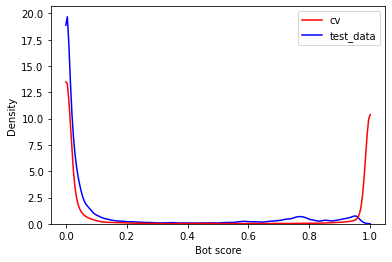

In [50]:
graph = sns.kdeplot(data=predicted, common_norm=False, clip=(0,1), bw_adjust=0.2, palette=['r', 'b'])
graph.set(xlabel="Bot score")

fig = graph.get_figure()
fig4a_name = "top_model_fig4a.png" if show_top_model else "fig4a.png"
fig.savefig(os.path.join(results_path, fig4a_name))

          test_data cv_data         0
threshold                            
NaN             NaN     NaN  0.000000
NaN             NaN     NaN  0.883025
NaN             NaN     NaN  0.582295
NaN             NaN     NaN  0.020000
NaN             NaN     NaN  0.939742
...             ...     ...       ...
NaN             NaN     NaN  0.003627
NaN             NaN     NaN  0.949362
NaN             NaN     NaN  1.000000
NaN             NaN     NaN  0.000314
NaN             NaN     NaN  0.905809

[153 rows x 3 columns]


/tmp/ipykernel_2141/3625097265.py:1: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  graph = sns.lineplot(data=threshold_f1, palette=['b', 'r'])


TypeError: reduction operation 'argmax' not allowed for this dtype

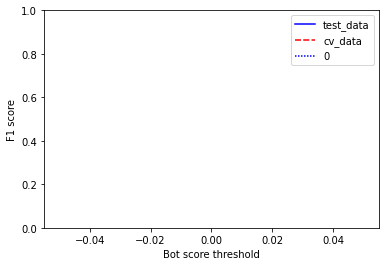

In [53]:

graph = sns.lineplot(data=threshold_f1, palette=['b', 'r'])
graph.set(xlabel="Bot score threshold", ylabel="F1 score", ylim=(0,1))

#get index of observation with highest f1_score, then retrieve its threshold
maxes = threshold_f1.idxmax(axis=0)
max_test_f1_threshold = maxes["test_data"]
max_cv_f1_threshold = maxes["cv_data"]


graph.axvline(max_test_f1_threshold, linestyle="--", color="blue")
graph.axvline(max_cv_f1_threshold, linestyle="--", color="red")

fig = graph.get_figure()

fig4b_name = "top_model_fig4b.png" if show_top_model else "fig4b.png"
fig.savefig(os.path.join(results_path, fig4b_name))

In [19]:
#load results
stds = pd.read_csv(os.path.join(results_path, "std.csv"))
#make all the strings 7 digits long by adding zeros in front
stds["name"] = stds.apply(lambda row: "M" + str(int(row["name"])).zfill(7), axis=1)

stds["std_rank"] = stds.mean(numeric_only=True, axis=1).rank()

stds.sort_values("std_rank")

stds_ranks = stds.merge(ranked_results, on="name")


train_datasets_size = [len(df) for df in datasets[:7]]

def get_train_size(model_name):
  name = model_name.strip("M")
  size = 0
  
  for i, c in enumerate(name):
    if c == "1":
      size += train_datasets_size[i]

  return size

stds_ranks["train_size"] = stds.apply(lambda row: get_train_size(row["name"]), axis=1)

#correlation between avg std rank (lower std lower/better rank) to model performance rank

stds_ranks[["std_rank", "rank", "train_size"]].corr(method="spearman")


,std_rank,rank,train_size
std_rank,1.000000,0.333072,-0.299544
rank,0.333072,1.000000,-0.137851
train_size,-0.299544,-0.137851,1.000000
